In [14]:
import sys
sys.path.append('../.')


from utils import *
from DataGenerator import *
from Models.Models_normal import *
import torch.optim as optim
from Analysis import fixed_model_batch_analysis
from DataLoader import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor


In [8]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('../running_scripts/all_results/sept_result_mnist/mnist_training/try_num0/epoch_60/model.pth', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [9]:
def plot_data_projection(ax, counter, anim_pieces, type_analysis='pca', dim=2, title='layers: ', labels_all: list = []):

    labels = labels_all[0]
    
    # Find unique labels and the number of unique classes
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    
    # Dynamically select an appropriate colormap
    if num_classes <= 10:
        cmap = plt.get_cmap('tab10')  # type: ignore # Use tab10 for 10 or fewer classes
    elif num_classes <= 20:
        cmap = plt.get_cmap('tab20')  # type: ignore # Use tab20 for 11-20 classes
    else:
        cmap = plt.cm.get_cmap('viridis', num_classes)  # type: ignore # Use continuous colormap for more than 20 classes
    
    # Map each unique label to a specific color in the colormap
    color_map = {label: cmap(i / num_classes) for i, label in enumerate(unique_labels)}
    
    # Assign colors to each data point based on its label
    colors = [color_map[label] for label in labels]
    
    # Select appropriate scatter plot based on dimension
    if dim == 2:
        ax.scatter(anim_pieces[counter][0], anim_pieces[counter][1], c=colors, s=10)
    elif dim == 3:
        ax.scatter(anim_pieces[counter][0], anim_pieces[counter][1], anim_pieces[counter][2], c=colors, s=10)
    
    # If labels are provided, add a legend
    if labels is not None:
        # Create a list of legend handles
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label],  # type: ignore
                              markersize=8, label=f'Class {label}') for label in unique_labels]
        
        # Add the legend to the axis
        ax.legend(handles=handles, title="Classes", loc="best")
    
    ax.grid(True)

    if type_analysis == 'pca':
        ax.set_xlabel('First Principal Component')
        ax.set_ylabel('Second Principal Component')
        if dim == 2:
            # ax.quiver([0, 0], eigenvectors[0][:, -1][0], eigenvectors[0][:, -1][1])
            # ax.quiver([0, 0], eigenvectors[0][:, -2][0], eigenvectors[0][:, -2][1])
            ax.set_title('Data in First Two Principal Components')
        if dim == 3:
            ax.set_zlabel('Third Principal Component')
            ax.set_title('Data in First Three Principal Components')
    elif type_analysis == 'random':
        ax.set_xlabel('First Random Diemnsion')
        ax.set_ylabel('Second Random Dimension')
        ax.set_title('Data in Two Random Dimension')
        if dim == 2:
            ax.set_title('Data in Two Random Dimension')
        if dim == 3:
            ax.set_zlabel('Third Random Dimension')
            ax.set_title('Data in Three Random Dimension')
    if type(title) is list:
        ax.set_title(title[counter])
    else:
        ax.set_title(f'{title} {counter + 1}')

    return colors

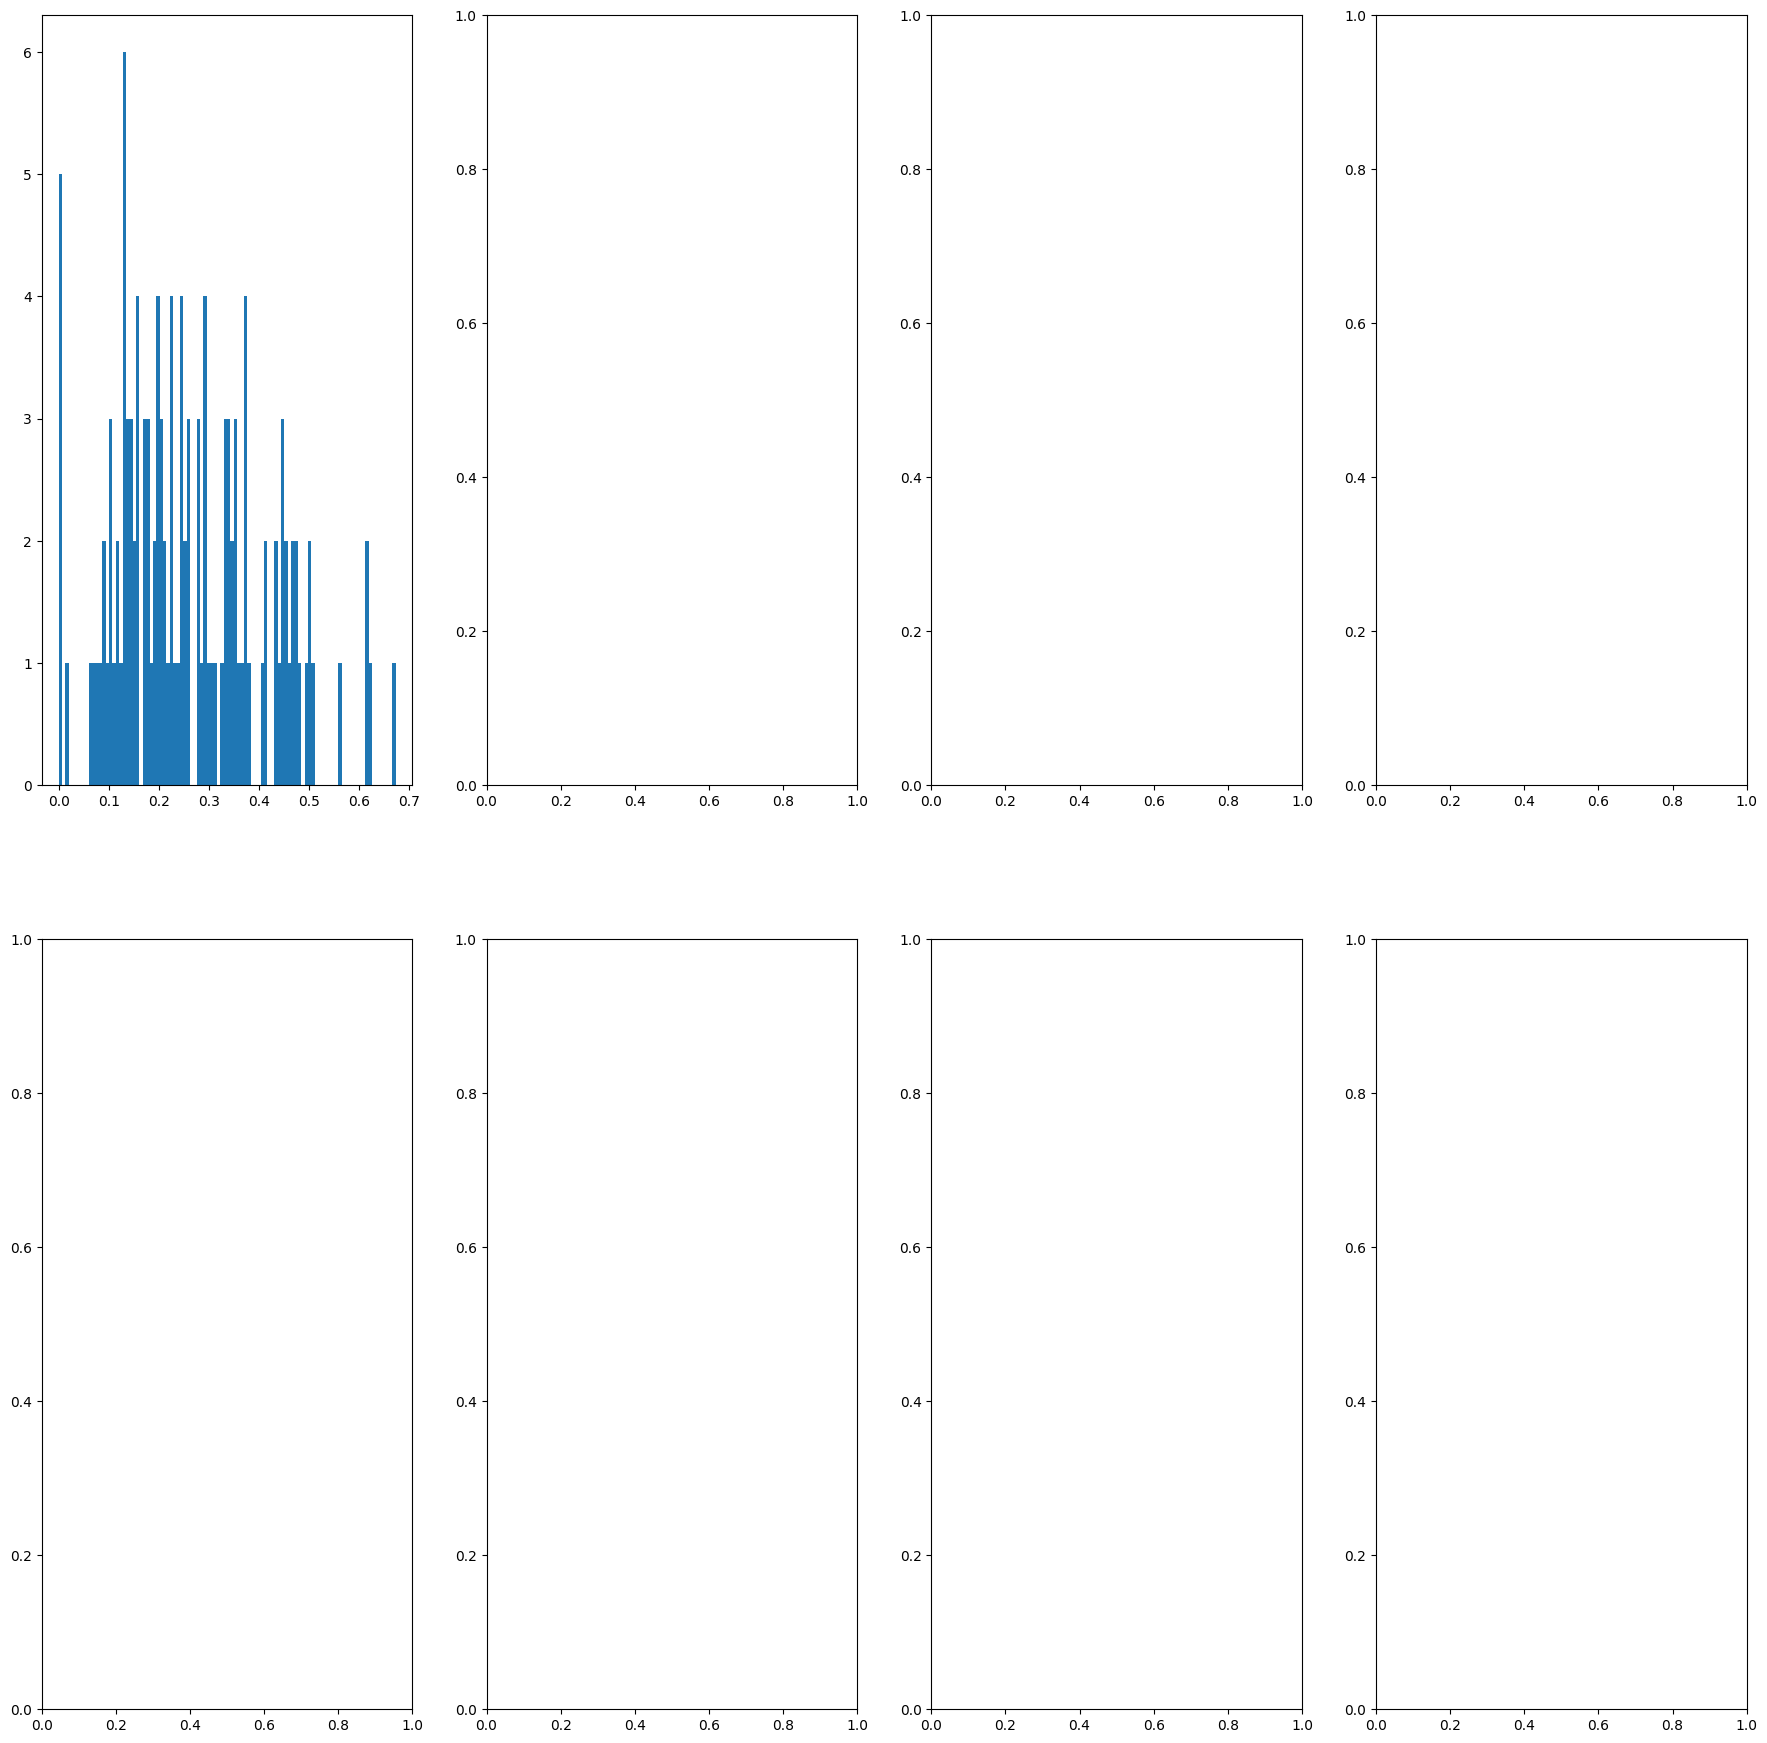

---


In [30]:
anal_path = '../spike_analysis/spike_resume_new_version_val/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, val_samples, val_labels, device, '{}_{}'.format(anal_path, 'val_'), 'analyze')
plt.close()
print("---")

In [31]:
def spike_detection_nd(points, max_hyperplanes=7, min_points_for_hyperplane=100, residual_threshold=0.5, merge_threshold=0.01):
    residual_threshold *= (points.shape[1] - 1)
    # merge_threshold *= (points.shape[1])
    def fit_hyperplane_ransac(points):
        n_dims = points.shape[1]
        dependent_dim = np.random.randint(n_dims)
        
        X = np.delete(points, dependent_dim, axis=1)
        y = points[:, dependent_dim]
        
        ransac = RANSACRegressor(LinearRegression(), 
                                 max_trials=1000, 
                                 min_samples=n_dims,
                                 residual_threshold=residual_threshold,
                                 stop_probability=0.99)
        ransac.fit(X, y)
        return ransac, dependent_dim

    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_
        
        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        full_coef[dependent_dim] = -1
        
        return full_coef, intercept

    def point_to_hyperplane_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)

    def hyperplane_distance(coef1, intercept1, coef2, intercept2):
        # Calculate the angle between the normal vectors of the hyperplanes
        cos_angle = np.dot(coef1, coef2) / (np.linalg.norm(coef1) * np.linalg.norm(coef2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        
        # Calculate the distance between the hyperplanes at the origin
        d = np.abs(intercept1 - intercept2) / np.linalg.norm(coef1)
        
        return angle, d

    n_dims = points.shape[1]
    hyperplanes = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0

    for _ in range(max_hyperplanes):
        if len(remaining_points) < min_points_for_hyperplane:
            break
        
        ransac, dependent_dim = fit_hyperplane_ransac(remaining_points)
        coef, intercept = get_hyperplane_eq(ransac, dependent_dim, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        hyperplane_error = sum(point_to_hyperplane_distance(p, coef, intercept) for p in inlier_points)
        total_error += hyperplane_error
        
        hyperplanes.append((coef, intercept, len(inlier_points), hyperplane_error))
        assigned_points.append(inlier_points)
        
        remaining_points = remaining_points[~inlier_mask]

    # Assign remaining points to the nearest hyperplane
    for point in remaining_points:
        distances = [point_to_hyperplane_distance(point, coef, intercept) for coef, intercept, _, _ in hyperplanes]
        nearest_hyperplane_index = np.argmin(distances)
        total_error += distances[nearest_hyperplane_index]
        assigned_points[nearest_hyperplane_index] = np.vstack([assigned_points[nearest_hyperplane_index], point])

    # Merge close hyperplanes
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(hyperplanes[i][0], hyperplanes[i][1], hyperplanes[j][0], hyperplanes[j][1])
            # if angle < merge_threshold and dist < merge_threshold:
            if angle < merge_threshold:
                # Merge hyperplanes
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_intercept = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])
                
                hyperplanes[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points
                
                # Remove the merged hyperplane
                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # Sort hyperplanes by number of inliers (descending)
    hyperplanes = sorted(zip(hyperplanes, assigned_points), key=lambda x: x[0][2], reverse=True)
    hyperplanes, assigned_points = zip(*hyperplanes)

    return hyperplanes, total_error, assigned_points


def assign_points_to_hyperplanes(points, hyperplanes):
        """
        Efficiently assign points to the closest hyperplane and calculate the error.

        Parameters:
        points: numpy array of shape (n_points, n_dimensions)
        hyperplanes: list of tuples (coef, intercept), where coef is a numpy array

        Returns:
        assignments: numpy array of shape (n_points,) containing hyperplane indices
        total_error: float, sum of distances from points to their assigned hyperplanes
        hyperplane_errors: list of errors for each hyperplane
        """
        n_points, n_dims = points.shape
        n_hyperplanes = len(hyperplanes)

        # Prepare hyperplane coefficients and intercepts
        coefs = torch.Tensor([h[0] for h in hyperplanes]).to(points.device)
        intercepts = torch.Tensor([h[1] for h in hyperplanes]).to(points.device)

        # Calculate distances from each point to each hyperplane
        # Using broadcasting to avoid explicit loops
        distances = torch.abs(torch.matmul(points, coefs.T) + intercepts) / torch.linalg.norm(coefs, dim=1)

        # Find the closest hyperplane for each point
        assignments = torch.argmin(distances, dim=1)

        # Calculate the total error
        total_error = torch.sum(torch.min(distances, dim=1)[0])

        # Calculate error for each hyperplane
        hyperplane_errors = [torch.sum(distances[assignments == i, i]) for i in range(n_hyperplanes)]

        return assignments, total_error, hyperplane_errors

In [36]:
len(results_dict[key])

12

In [42]:
mnist_labels =  val_labels.detach().cpu().numpy()
mnist_data = val_samples.detach().cpu().numpy().reshape(val_samples.shape[0], 28 * 28)
# Number of classes
num_classes = len(np.unique(mnist_labels))
key = 'pca_2'

for idx_layer in tqdm(range(len(results_dict[key]))):

    mnist_pca_2d = np.array(results_dict[key][idx_layer]).transpose()

    # Create the overall figure
    fig = plt.figure(figsize=(36, 50))
    outer_grid = fig.add_gridspec(num_classes + 1, 2, width_ratios=[1.2, 1.8], height_ratios=[1] + [0.6] * num_classes)


    # Original PCA plot for the entire dataset
    ax_pca = fig.add_subplot(outer_grid[0, 0])
    ax_pca.set_title('2D PCA of Original MNIST Dataset')

    colors = np.array(plot_data_projection(ax_pca, idx_layer, results_dict[key], labels_all=results_dict['labels']))


    # Process each class for clustering and sample visualization
    for class_idx in range(num_classes):
        # Extract the data points belonging to the current class
        class_data_indices = np.where(mnist_labels == class_idx)[0]
        class_data = mnist_pca_2d[class_data_indices]
        mnist_class_data = mnist_data[np.where(mnist_labels == class_idx)[0]]

        points = class_data.copy()

        # Apply iterative line fitting clustering to the class data
        # clusters, cluster_indices = iterative_line_fitting(class_data)
        detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)
        assignments, _, _ = assign_points_to_hyperplanes(torch.Tensor(points), detected_hyperplanes)

        # Plot the clustering for the current class
        class_cluster_ax = fig.add_subplot(outer_grid[class_idx + 1, 0])
        class_cluster_ax.set_title(f'Clustering of Class {class_idx} (PCA Reduced)')
        for cluster_idx in range(len(detected_hyperplanes)):
            cluster_color = colors[cluster_idx % len(colors)]
            class_cluster_ax.scatter(points[assignments == cluster_idx, 0], points[assignments == cluster_idx, 1], label=f'Spike {cluster_idx + 1}', color=cluster_color)
        class_cluster_ax.set_xlabel('First Principal Component')
        class_cluster_ax.set_ylabel('Second Principal Component')
        class_cluster_ax.legend(title='Clusters')

        # Create a grid to hold the sample images for each cluster of the current class
        # sample_grid = fig.add_subplot(outer_grid[class_idx + 1, 1])
        cluster_gridspec = gridspec.GridSpecFromSubplotSpec(1, len(detected_hyperplanes), subplot_spec=outer_grid[class_idx + 1, 1], wspace=0.3)

        for cluster_idx in range(len(detected_hyperplanes)):
            cluster = class_data[assignments == cluster_idx]
            # Create a subplot for each cluster to contain its samples
            cluster_ax = fig.add_subplot(cluster_gridspec[0, cluster_idx])
            cluster_ax.axis('off')
            cluster_ax.set_title(f'Cluster {cluster_idx + 1}', fontsize=10)

            # Plot 15 random samples for the current cluster in a 3x5 grid
            num_samples = min(60, len(cluster))
            rows, cols = 6, 10
            grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=cluster_gridspec[0, cluster_idx], wspace=0.1, hspace=0.1)

            for sample_idx in range(num_samples):
                random_idx = np.random.choice(np.where(assignments == cluster_idx)[0])
                sample_image = mnist_class_data[random_idx].reshape(28, 28)
                
                # Determine position within the 3x5 grid
                row, col = divmod(sample_idx, cols)
                sub_ax = fig.add_subplot(grid[row, col])
                sub_ax.imshow(sample_image, cmap='gray')
                sub_ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add spacing to avoid overlap
    fig.savefig(f"{anal_path}spike_plot{idx_layer}.png")
    plt.close()

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [09:59<00:00, 49.97s/it]
